<a href="https://colab.research.google.com/github/shafiqayusaidi/cell-image-segmentation/blob/main/Project_4_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-pwdcb0j9
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-pwdcb0j9


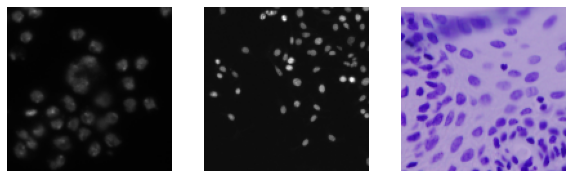

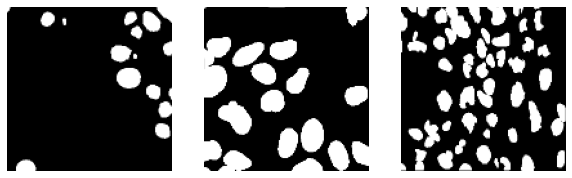

In [23]:
#Import necessary packages
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import datetime

#1. Data loading
train_file_directory = r"/content/drive/MyDrive/data-science-bowl-2018-2/train"
test_file_directory = r"/content/drive/MyDrive/data-science-bowl-2018-2/test"
#%%
#1.2. Load the images
def load_images(file_path):
    images=[]
    for image_file in os.listdir(file_path):
        img = cv2.imread(os.path.join(file_path,image_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(128,128))
        images.append(img)
    return images

train_image_dir = os.path.join(train_file_directory,'inputs')
train_images = load_images(train_image_dir)
test_image_dir = os.path.join(test_file_directory,'inputs')
test_images = load_images(test_image_dir)
    
#1.3. Load the masks
def load_masks(file_path):
    masks=[]
    for mask_file in os.listdir(file_path):
        mask = cv2.imread(os.path.join(file_path,mask_file),cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(128,128))
        masks.append(mask)
    return masks
    
train_mask_dir = os.path.join(train_file_directory,'masks')
train_masks = load_masks(train_mask_dir)
test_mask_dir = os.path.join(test_file_directory,'masks')
test_masks = load_masks(test_mask_dir)
    
#1.4. Convert images and masks into numpy array
train_images_np = np.array(train_images)
train_masks_np = np.array(train_masks)
test_images_np = np.array(test_images)
test_masks_np = np.array(test_masks)

#%%
#1.5. Check some examples
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img_plot = train_images[i]
    plt.imshow(img_plot)
    plt.axis('off')
plt.show()   

plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    mask_plot = train_masks[i]
    plt.imshow(mask_plot, cmap='gray')
    plt.axis('off')
plt.show()   


In [24]:
#2. Data preprocessing
#2.1. Expand the mask dimension
train_masks_np_exp = np.expand_dims(train_masks_np,axis=-1)
test_masks_np_exp = np.expand_dims(test_masks_np,axis=-1)
#Check the mask output
print(train_masks[0].min(),train_masks[0].max())

#%%
#2.2. Change the mask value (Encode into numerical encoding, binary 1 and 0)
train_conv_masks = np.round(train_masks_np_exp/255)
train_conv_masks = 1 - train_conv_masks

test_conv_masks = np.round(test_masks_np_exp/255)
test_conv_masks = 1 - test_conv_masks

#%%
#2.3. Normalize the images
converted_images_train = train_images_np / 255.0
converted_images_test = test_images_np/255.0

#%%
#2.4. Do train-validation split
SEED = 12345
x_train,x_val,y_train,y_val = train_test_split(converted_images_train,converted_masks_train,test_size=0.2,random_state=SEED)

#%%
#2.5. Convert the numpy array into tensor slice
train_x = tf.data.Dataset.from_tensor_slices(x_train)
val_x = tf.data.Dataset.from_tensor_slices(x_val)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
val_y = tf.data.Dataset.from_tensor_slices(y_val)
test_x = tf.data.Dataset.from_tensor_slices(converted_images_test)
test_y = tf.data.Dataset.from_tensor_slices(converted_masks_test)

#%%
#2.6. Zip tensor slice into dataset
train = tf.data.Dataset.zip((train_x,train_y))
val = tf.data.Dataset.zip((val_x,val_y))
test = tf.data.Dataset.zip((test_x,test_y))

#%%
#2.7. Convert into prefetch dataset
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 800//BATCH_SIZE
VALIDATION_STEPS = 200//BATCH_SIZE
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train = train.prefetch(buffer_size=AUTOTUNE)
val = val.batch(BATCH_SIZE).repeat()
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

#Data preparation completed

0 255


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_3 (Functional)           [(None, 64, 64, 96)  1841984     ['input_5[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

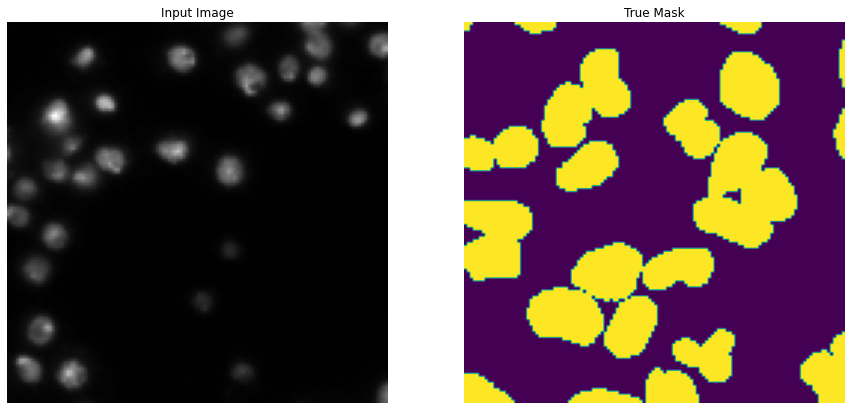

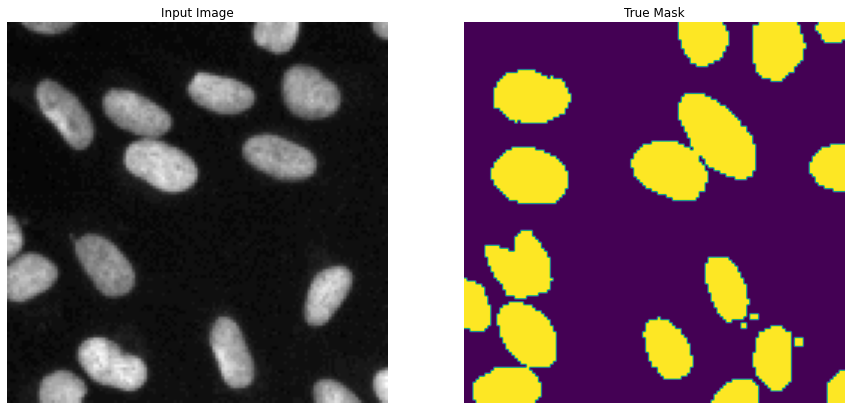

In [25]:
#3. Prepare model
#We are going to create a modifed version of U-net
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

# Use the activations of those layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

#Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

#Define the upsampling stack
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

#Function to create the entire modified U-net
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

#Define the model
OUTPUT_CLASSES = 2
model = unet_model(output_channels=OUTPUT_CLASSES)

#%%
#Compile the model and display the model structure
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

#%%
#Create a function to display some examples
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image','True Mask','Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list),i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for images, masks in train.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image,sample_mask])
    
#%%
#Create a function to process predicted mask
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask,axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

#Create a function to display prediction
def show_predictions(dataset=None,num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0],mask[0],create_mask(pred_mask)[0]])
    else:
        display([sample_image,sample_mask,create_mask(model.predict(sample_image[tf.newaxis,...]))[0]])

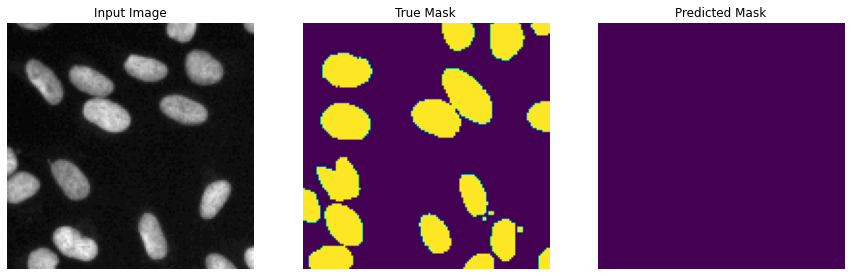


 Sample prediction after epoch 8

50/50 [==============================] - 7s 149ms/step - loss: 0.4242 - accuracy: 0.8482 - val_loss: 0.4463 - val_accuracy: 0.8474
Epoch 8: early stopping
5/5 [==============================] - 0s 34ms/step - loss: 0.4647 - accuracy: 0.8341
Test loss = 0.4646790623664856
Test accuracy = 0.8341237306594849


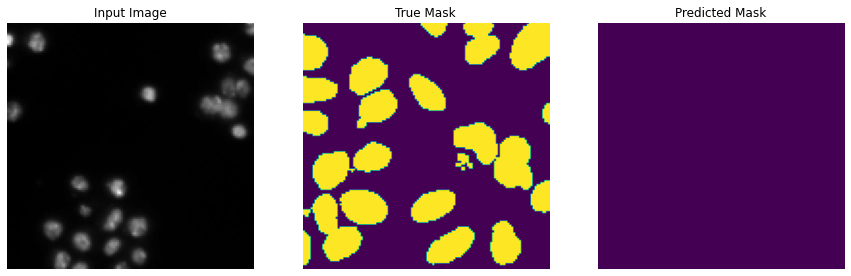

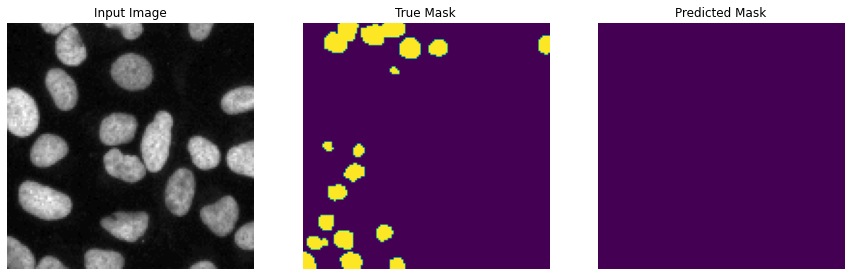

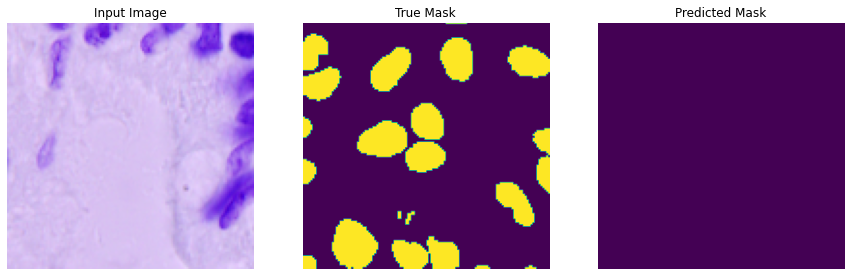

In [26]:
#Custom callback to display result during training
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\n Sample prediction after epoch {}\n'.format(epoch+1))

#Tensorboard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir,histogram_freq=1,profile_batch=0)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=2)

#4. Start to do training
EPOCH = 100

history = model.fit(train,epochs=EPOCH,steps_per_epoch=STEPS_PER_EPOCH,batch_size=BATCH_SIZE,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=val,
                    callbacks=[DisplayCallback(),tb_callback,es_callback])

#%%
#Test evaluation
test_loss, test_accuracy = model.evaluate(test)
print(f"Test loss = {test_loss}")
print(f"Test accuracy = {test_accuracy}")

#%%
#Deploy model by using the show_prediction functions created before
show_predictions(test,3)

In [27]:
try:
  model_history = model.fit(train, epochs=EPOCH,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


In [28]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

In [29]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [30]:
train.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [31]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [34]:
weighted_model.fit(
    train.map(add_sample_weights),
    epochs=50,
    steps_per_epoch=100)

Epoch 1/50
100/100 [==============================] - 8s 76ms/step - loss: 0.1036 - accuracy: 0.8978
Epoch 2/50
100/100 [==============================] - 7s 75ms/step - loss: 0.1027 - accuracy: 0.8986
Epoch 3/50
100/100 [==============================] - 7s 75ms/step - loss: 0.0943 - accuracy: 0.9068
Epoch 4/50
100/100 [==============================] - 7s 75ms/step - loss: 0.0932 - accuracy: 0.9080
Epoch 5/50
100/100 [==============================] - 7s 74ms/step - loss: 0.0830 - accuracy: 0.9180
Epoch 6/50
100/100 [==============================] - 7s 75ms/step - loss: 0.0840 - accuracy: 0.9165
Epoch 7/50
100/100 [==============================] - 7s 75ms/step - loss: 0.0770 - accuracy: 0.9238
Epoch 8/50
100/100 [==============================] - 7s 75ms/step - loss: 0.0732 - accuracy: 0.9277
Epoch 9/50
100/100 [==============================] - 7s 74ms/step - loss: 0.0743 - accuracy: 0.9266
Epoch 10/50
100/100 [==============================] - 7s 75ms/step - loss: 0.0710 - accura